In [1]:
import pandas as pd
import matplotlib.pylab as plt
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np
%matplotlib inline
 
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
 


# sales_data = pd.read_csv('retail_sales.csv')
# sales_data['date']=pd.to_datetime(sales_data['date'])
# sales_data.set_index('date', inplace=True)
 
# sales_data.plot()

/home/cooldudeanmol/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = pd.read_csv("household_power_consumption.csv")
data['Date'] = data['Date'].astype('str')
data['Time'] = data['Time'].astype('str')
data['Date'] = data['Date'] + ' '+ data['Time']
data['Date'] = pd.to_datetime(data['Date'], format = "%d-%m-%Y %H:%M:%S" )
# data['Date'] = pd.to_datetime(data['Date'], format = "%d-%m-%Y" )
data.head()



/home/cooldudeanmol/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
data = data.assign(Date=data.Date.dt.round('H'))
data.index = pd.to_datetime(data.index)
data = data.reset_index().drop_duplicates(subset='Date', keep='last').set_index('Date')
data = data['Global_active_power']
data.head()


Date
2006-12-16 17:00:00    3.520
2006-12-16 18:00:00    2.930
2006-12-16 19:00:00    3.614
2006-12-16 20:00:00    3.262
2006-12-16 21:00:00    3.420
Name: Global_active_power, dtype: object

In [4]:
data = data[data != '?']
data.head()
len(data)

34155

In [5]:
data.columns = ['Energy Production']
data.head()

Date
2006-12-16 17:00:00    3.520
2006-12-16 18:00:00    2.930
2006-12-16 19:00:00    3.614
2006-12-16 20:00:00    3.262
2006-12-16 21:00:00    3.420
Name: Global_active_power, dtype: object

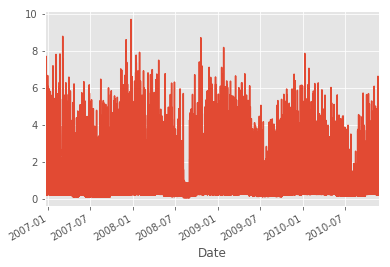

In [6]:
data = data.astype('float64')
data.head()
data.plot()

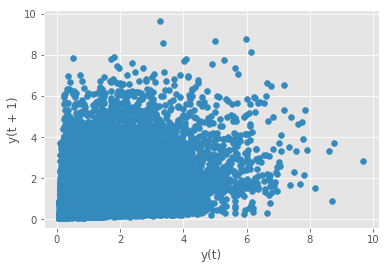

In [7]:
pd.plotting.lag_plot(data)

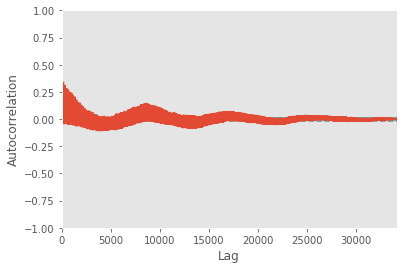

In [8]:
pd.plotting.autocorrelation_plot(data)

In [9]:
data.corr(data.shift(48))

0.30049792294043737

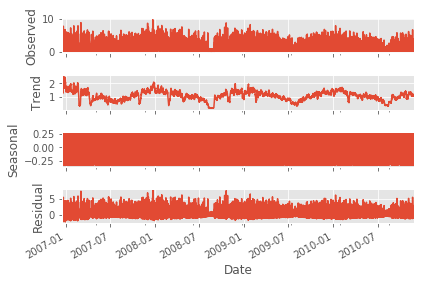

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(data, model='additive', freq=96)
x = decomposed.plot() #See note below about this

In [11]:
dt = data.copy(deep=True)
dt= data.diff()
dt= data.diff()
dt= data.diff()
dt= data.diff()
# dt['Energy Production'] = dt['Energy Production'].diff()
# dt['Energy Production'] = dt['Energy Production'].diff()
# dt['Energy Production'] = dt['Energy Production'].diff()

In [12]:
data.head()

Date
2006-12-16 17:00:00    3.520
2006-12-16 18:00:00    2.930
2006-12-16 19:00:00    3.614
2006-12-16 20:00:00    3.262
2006-12-16 21:00:00    3.420
Name: Global_active_power, dtype: float64

In [13]:
dt = dt.iloc[4:]
dt.head()

Date
2006-12-16 21:00:00    0.158
2006-12-16 22:00:00   -1.032
2006-12-16 23:00:00    0.046
2006-12-17 00:00:00   -2.148
2006-12-17 01:00:00    1.794
Name: Global_active_power, dtype: float64

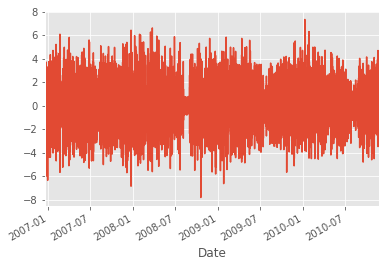

In [14]:
dt.plot()

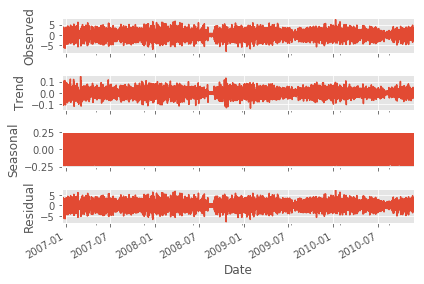

In [15]:
decomposed = seasonal_decompose(dt, model='additive', freq=48)
x = decomposed.plot()

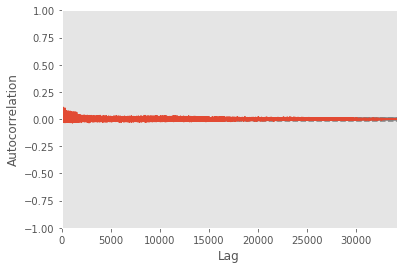

In [16]:
pd.plotting.autocorrelation_plot(dt)

In [17]:
from statsmodels.tsa.ar_model import AR
 
#create train/test datasets
X = dt.dropna()
train_data = X[:int((len(X)*70)/100)]
test_data = X[int((len(X)*70)/100):]
 
#train the autoregression model
model = AR(train_data)
model_fitted = model.fit()

/home/cooldudeanmol/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [18]:
print('The lag value chose is: %s' % model_fitted.k_ar)
 
 
print('The coefficients of the model are:\n %s' % model_fitted.params)
 


The lag value chose is: 47
The coefficients of the model are:
 const                     -0.000482
L1.Global_active_power    -0.635820
L2.Global_active_power    -0.530507
L3.Global_active_power    -0.500767
L4.Global_active_power    -0.481415
L5.Global_active_power    -0.477253
L6.Global_active_power    -0.468338
L7.Global_active_power    -0.485290
L8.Global_active_power    -0.477733
L9.Global_active_power    -0.477792
L10.Global_active_power   -0.457748
L11.Global_active_power   -0.427344
L12.Global_active_power   -0.388506
L13.Global_active_power   -0.371482
L14.Global_active_power   -0.364923
L15.Global_active_power   -0.373781
L16.Global_active_power   -0.377888
L17.Global_active_power   -0.374969
L18.Global_active_power   -0.372975
L19.Global_active_power   -0.374156
L20.Global_active_power   -0.370099
L21.Global_active_power   -0.363955
L22.Global_active_power   -0.333861
L23.Global_active_power   -0.265766
L24.Global_active_power   -0.161595
L25.Global_active_power   -0.132758
L

/home/cooldudeanmol/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


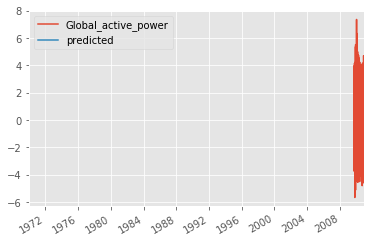

In [19]:
# make predictions 
predictions = model_fitted.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)
 
# create a comparison dataframe
compare_df = pd.concat(
    [X[int((len(X)*70)/100):],
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})
 
#plot the two values
compare_df.plot()

In [20]:
from sklearn.metrics import r2_score
 
r2 = r2_score(X[int((len(X)*70)/100):], predictions)
r2

0.000970311008375857

In [21]:
import math
from sklearn.metrics import mean_squared_error


# trainPredict = scaler.inverse_transform(trainPredict)
# testPredict = scaler.inverse_transform(testPredict)

# ytrain = scaler.inverse_transform([Ytrain])
# ytest = scaler.inverse_transform([Ytest])
    
# trainScore = math.sqrt(mean_squared_error(ytrain[0], X[:int((len(X)*70)/100)]))    
# print("train Score", trainScore)

testScore = math.sqrt(mean_squared_error(X[int((len(X)*70)/100):], predictions))    
print("train Score", testScore)
# print(ytest[0])

train Score 0.9910497190400125
